In [35]:
#Import Required Libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
import requests   # For reading the URL
from bs4 import BeautifulSoup #for data processing 
import re  # for content processing

print('Libraries imported.')

Libraries imported.


## Data Acquisition Process Steps 

### Acquire data from wikipedia for hyderabad neighbourhoods 

In [180]:
#Enable Intellisense
%config IPCompleter.greedy=True

In [181]:
wiki_link='https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India'
page=requests.get(wiki_link)
print(page.content)

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Category:Neighbourhoods in Hyderabad, India - Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XhcI9wpAIC8AAE1solMAAABR","wgCSPNonce":!1,"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":14,"wgPageName":"Category:Neighbourhoods_in_Hyderabad,_India","wgTitle":"Neighbourhoods in Hyderabad, India","wgCurRevisionId":881961440,"wgRevisionId":881961440,"wgArticleId":3839100,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgC

In [182]:
# Create a soup object for parsing
soup = BeautifulSoup(page.content, 'html.parser')
soup.prettify()  # Helps in seperating HTML tags on new lines 


'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   Category:Neighbourhoods in Hyderabad, India - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XhcI9wpAIC8AAE1solMAAABR","wgCSPNonce":!1,"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":14,"wgPageName":"Category:Neighbourhoods_in_Hyderabad,_India","wgTitle":"Neighbourhoods in Hyderabad, India","wgCurRevisionId":881961440,"wgRevisionId":881961440,"wgArticleId":3839100,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUs

In [183]:
#All neighborhoods are enclosed in div tag of class 'mw-category-group'
neighborhood_tag=soup.find_all('div', attrs={'class':'mw-category-group'})


In [184]:
soup_neighborhood=BeautifulSoup(str(neighborhood_tag), 'html.parser') # Object to read HTML from earlier soup object
lst_neighborhoods=[]  # Define an empty list for neighbourhoods names
lst_neighborhoods_links=[]  # Define an empty list for neighbourhoods detail links
all_links=soup_neighborhood.find_all('a')
for a in all_links:
    lst_neighborhoods.append(a['title'].strip())
    lst_neighborhoods_links.append(a['href'].strip())
lst_neighborhoods
lst_neighborhoods_links

['/wiki/A._S._Rao_Nagar',
 '/wiki/A.C._Guards',
 '/wiki/Abhyudaya_Nagar',
 '/wiki/Abids',
 '/wiki/Adikmet',
 '/wiki/Afzal_Gunj',
 '/wiki/Aghapura',
 '/wiki/Aliabad,_Hyderabad',
 '/wiki/Alijah_Kotla',
 '/wiki/Allwyn_Colony',
 '/wiki/Alwal',
 '/wiki/Amberpet',
 '/wiki/Ameerpet',
 '/wiki/Ashok_Nagar,_Hyderabad',
 '/wiki/Asif_Nagar',
 '/wiki/Attapur',
 '/wiki/Azamabad,_Hyderabad',
 '/wiki/Azampura',
 '/wiki/Badichowdi',
 '/wiki/Bagh_Lingampally',
 '/wiki/Bairamalguda',
 '/wiki/Balkampet',
 '/wiki/Banjara_Hills',
 '/wiki/Bank_Street,_Hyderabad',
 '/wiki/Barkas,_Hyderabad',
 '/wiki/Barkatpura',
 '/wiki/Basheerbagh',
 '/wiki/Bazarghat',
 '/wiki/Begum_Bazaar',
 '/wiki/Begumpet',
 '/wiki/Bharat_Nagar',
 '/wiki/BHEL_Township,_Hyderabad',
 '/wiki/BJR_Nagar',
 '/wiki/Boggulkunta',
 '/wiki/Borabanda',
 '/wiki/Bowenpally',
 '/wiki/Brahman_Vaadi',
 '/wiki/Chaderghat',
 '/wiki/Champapet',
 '/wiki/Chanchalguda',
 '/wiki/Chandrayan_Gutta',
 '/wiki/Chatta_Bazaar',
 '/wiki/Cherlapally',
 '/wiki/Chikkadpal

### We have the two lists as 
1. lst_neighborhoods  - Having Neighborhoods Names  
2. lst_neighborhoods_links - Having links for Neighborhood Details Page

### Define a function to read the neighborhood detail page for latitude and longitude information

In [185]:
def get_lat_long(lnk):
    plink='https://en.wikipedia.org'+lnk  ###Add the Starting web page address
    wpage=requests.get(plink)
    psoup = BeautifulSoup(wpage.content, 'html.parser')
    psoup.prettify()
    latitude=psoup.find('span', attrs={'class':'latitude'})  # Latitude in span class latitude
    if(latitude!=None):   # For some Neighborhoods Latitide and Longitude inforation is not publisded 
        latitude=latitude.text.strip()
    else :
        latitude="0"
    longitude=psoup.find('span', attrs={'class':'longitude'})  # Longitude in span class longitude 
    if(longitude!=None):   # for some longitude information is not given
         longitude=longitude.text.strip()
    else :
         longitude="0"
    psoup=''
    return latitude,longitude

### Define a function for converting Latitude & Longitude information from degree, minutes & seconds to decimal

In [186]:
def parse_dms(dms):
    dms_str = re.sub(r'\s', '', dms)
    sign = -1 if re.search('[swSW]', dms_str) else 1
    numbers =[*filter(len, re.split('[°\'\′\″"wWnNeEsS]+', dms_str, maxsplit=4))]
    degree = numbers[0]
    minute = numbers[1] if len(numbers) >= 2 else '0'
    second = numbers[2] if len(numbers) >= 3 else '0'
    return sign * (float(degree) + float(minute) / 60 + float(second) / 3600)

## Start web scrapping for individual Neighborhood Lat & Long information

In [187]:
lst_latitude=[]   # Create empty list for latitude
lst_longitude=[]  # Create empty list for longitude 

for neighborhood in lst_neighborhoods_links:
    print("Processing - ", neighborhood)
    lat,lng=get_lat_long(neighborhood)
    print(lat, ":", lng)
    lst_latitude.append(parse_dms(lat))  # Call Parse to convert into decimals
    lst_longitude.append(parse_dms(lng)) # Call Parse to convert into decimals
print("All Finished Successfully!")

Processing -  /wiki/A._S._Rao_Nagar
17°17′N : 78°19′E
Processing -  /wiki/A.C._Guards
17°23′49″N : 78°27′25″E
Processing -  /wiki/Abhyudaya_Nagar
18°59′28.96″N : 72°50′38.99″E
Processing -  /wiki/Abids
17°21′58″N : 78°28′34″E
Processing -  /wiki/Adikmet
17°24′25″N : 78°30′46″E
Processing -  /wiki/Afzal_Gunj
17°22′24″N : 78°28′15″E
Processing -  /wiki/Aghapura
17°23′18″N : 78°27′52″E
Processing -  /wiki/Aliabad,_Hyderabad
17°20′47″N : 78°28′13″E
Processing -  /wiki/Alijah_Kotla
17°21′26″N : 78°28′37″E
Processing -  /wiki/Allwyn_Colony
17°29′N : 78°25′E
Processing -  /wiki/Alwal
17°30′11″N : 78°30′25″E
Processing -  /wiki/Amberpet
17°23′27″N : 78°31′25″E
Processing -  /wiki/Ameerpet
0 : 0
Processing -  /wiki/Ashok_Nagar,_Hyderabad
17°24′25″N : 78°29′19″E
Processing -  /wiki/Asif_Nagar
17°23′22″N : 78°27′10″E
Processing -  /wiki/Attapur
17°23′45″N : 78°25′52″E
Processing -  /wiki/Azamabad,_Hyderabad
0 : 0
Processing -  /wiki/Azampura
17°22′34″N : 78°29′25″E
Processing -  /wiki/Badichowdi


17°25′24″N : 78°30′38″E
Processing -  /wiki/Pan_bazar
0 : 0
Processing -  /wiki/Parsigutta
17°25′45″N : 78°29′43″E
Processing -  /wiki/Patancheru
17°32′N : 78°16′E
Processing -  /wiki/Patny
17°26′25″N : 78°29′43″E
Processing -  /wiki/Pisal_Banda
0 : 0
Processing -  /wiki/Pragathi_Nagar
17°31′16″N : 78°23′47″E
Processing -  /wiki/Prakash_Nagar
0 : 0
Processing -  /wiki/Punjagutta
17°26′12″N : 78°26′38″E
Processing -  /wiki/Purana_pul
0 : 0
Processing -  /wiki/Putlibowli
17°22′53″N : 78°28′55″E
Processing -  /wiki/Quthbullapur
17°29′58″N : 78°27′30″E
Processing -  /wiki/Radha_Krishna_Nagar
0 : 0
Processing -  /wiki/Raidurg
0 : 0
Processing -  /wiki/Raj_Bhavan_Road
0 : 0
Processing -  /wiki/Ramachandrapuram,_Medak_district
17°18′N : 78°10′E
Processing -  /wiki/Ramanthapur
17°23′31″N : 78°32′18″E
Processing -  /wiki/Ramnagar,_Hyderabad
0 : 0
Processing -  /wiki/Rani_Gunj
17°25′48″N : 78°29′23″E
Processing -  /wiki/Rastrapathi_Road
0 : 0
Processing -  /wiki/Red_Hills,_Hyderabad
0 : 0
Proces

In [188]:
# Let's see what we got
print(lst_latitude[:10], ":", lst_longitude[:10])

[17.283333333333335, 17.396944444444443, 18.991377777777778, 17.366111111111113, 17.40694444444444, 17.373333333333335, 17.388333333333332, 17.34638888888889, 17.357222222222223, 17.483333333333334] : [78.31666666666666, 78.45694444444445, 72.84416388888889, 78.47611111111111, 78.51277777777777, 78.47083333333333, 78.46444444444445, 78.47027777777778, 78.47694444444444, 78.41666666666667]


### Convert all the lists into Dataframe for analysis

In [189]:
columns=['Neighborhood','Latitude', 'Longitude']
data=list(zip(lst_neighborhoods,lst_latitude, lst_longitude))

df_hyd_neighborhoods=pd.DataFrame(data, columns=columns)
df_hyd_neighborhoods.head(10)


,Neighborhood,Latitude,Longitude
0,A. S. Rao Nagar,17.283333,78.316667
1,A.C. Guards,17.396944,78.456944
2,Abhyudaya Nagar,18.991378,72.844164
3,Abids,17.366111,78.476111
4,Adikmet,17.406944,78.512778
5,Afzal Gunj,17.373333,78.470833
6,Aghapura,17.388333,78.464444
7,"Aliabad, Hyderabad",17.346389,78.470278
8,Alijah Kotla,17.357222,78.476944
9,Allwyn Colony,17.483333,78.416667


In [ ]:
# Save the dataframe to CSV file to avoid  rerunning data acquisition process 

df_hyd_neighborhoods.to_csv(r'df_hyd_neighborhoods.csv', index=False)

In [190]:
df_hyd_neighborhoods.shape

(200, 3)

### Data Acquisition & Processing Complete. We have 200 Neighborhoods in Hyderabad as per the data collected

In [17]:
#Read the df_canada_final created earlier from github
file_hyd_neighborhoods = "df_hyd_neighborhoods.csv"
df_hyd_neighborhoods = pd.read_csv(file_hyd_neighborhoods)
df_hyd_neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,A. S. Rao Nagar,17.283333,78.316667
1,A.C. Guards,17.396944,78.456944
2,Abhyudaya Nagar,18.991378,72.844164
3,Abids,17.366111,78.476111
4,Adikmet,17.406944,78.512778


  ### Use geopy library to get the latitude and longitude values of Hyderabad, India

In [75]:
address = 'Hyderabad, India'
geolocator = Nominatim(user_agent="hyd_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad are 17.38878595, 78.4610647345315.


### For some neighbourgoods coordinates were searched using google search and file was updated

In [4]:
#Check for 0 coordinates if any..
df_test=df_hyd_neighborhoods.loc[df_hyd_neighborhoods.Latitude==0]
df_test

,Neighborhood,Latitude,Longitude
124,"Mehboob ki Mehendi, Hyderabad",0.0,0.0


In [18]:
# Exclude above neighbourhood from the datafraeme
df_hyd_neighborhoods=df_hyd_neighborhoods[df_hyd_neighborhoods.Latitude!=0]
df_hyd_neighborhoods.shape

(199, 3)

### Create a map of Hyderabad to visualize the neighbourhoods

In [179]:
# create map of Hyderabad using latitude and longitude values
map_hyd = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_hyd_neighborhoods['Latitude'], df_hyd_neighborhoods['Longitude'],
                                  df_hyd_neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hyd)  
    
map_hyd

###  Use Foursquare API to explore the neighborhoods and segment

In [21]:
#Define Creditential 
# Define Foursquare Credentials and Version
LIMIT = 100
CLIENT_ID = '5QPNQVEQMF0Z4BLMVR5GXRTATAUTLJRH0523VBXNS1PER4UB' # your Foursquare ID
CLIENT_SECRET = 'QBG2MR3W2EAGQCF5CUK1UBGAOD43H4MA0JOIFCWWZ1SNXNOR' # your Foursquare Secret
VERSION = '20191101' # Foursquare API version
RADIUS=2000  # For venues within 3KM of the neighborhood
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5QPNQVEQMF0Z4BLMVR5GXRTATAUTLJRH0523VBXNS1PER4UB
CLIENT_SECRET:QBG2MR3W2EAGQCF5CUK1UBGAOD43H4MA0JOIFCWWZ1SNXNOR


### Explore neighborhoods

### We are going to use explore neighborhoods having specific venues. The catagoryID are taken from foursquare API documentations for hospitals, pharmacy, stationary store, India & chinese restaurants and convenience store  
- School 4bf58dd8d48988d13b941735
- Hospital 4bf58dd8d48988d196941735
- Pharmacy 4bf58dd8d48988d10f951735
- Stationery Store 52f2ab2ebcbc57f1066b8b21
- Indian Restaurant 4bf58dd8d48988d10f941735
- Convenience Store 4d954b0ea243a5684a65b473
- Chinese Restaurant 4bf58dd8d48988d145941735

In [26]:
venue_catagories='4bf58dd8d48988d13b941735,4bf58dd8d48988d196941735,4bf58dd8d48988d10f951735,52f2ab2ebcbc57f1066b8b21,4bf58dd8d48988d10f941735,4d954b0ea243a5684a65b473,4bf58dd8d48988d145941735'
print(venue_catagories)

4bf58dd8d48988d13b941735,4bf58dd8d48988d196941735,4bf58dd8d48988d10f951735,52f2ab2ebcbc57f1066b8b21,4bf58dd8d48988d10f941735,4d954b0ea243a5684a65b473,4bf58dd8d48988d145941735


In [23]:
#Define a function to return venues

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Processing :", name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT,
            venue_catagories)            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [25]:
#Get Venues for each row for Hyderabad

hyd_venues = getNearbyVenues(names=df_hyd_neighborhoods['Neighborhood'].tolist(),
                                   latitudes=df_hyd_neighborhoods['Latitude'].tolist(),
                                   longitudes=df_hyd_neighborhoods['Longitude'].tolist()
                            )

Processing : A. S. Rao Nagar
Processing : A.C. Guards
Processing : Abhyudaya Nagar
Processing : Abids
Processing : Adikmet
Processing : Afzal Gunj
Processing : Aghapura
Processing : Aliabad, Hyderabad
Processing : Alijah Kotla
Processing : Allwyn Colony
Processing : Alwal
Processing : Amberpet
Processing : Ameerpet
Processing : Ashok Nagar, Hyderabad
Processing : Asif Nagar
Processing : Attapur
Processing : Azamabad, Hyderabad
Processing : Azampura
Processing : Badichowdi
Processing : Bagh Lingampally
Processing : Bairamalguda
Processing : Balkampet
Processing : Banjara Hills
Processing : Bank Street, Hyderabad
Processing : Barkas, Hyderabad
Processing : Barkatpura
Processing : Basheerbagh
Processing : Bazarghat
Processing : Begum Bazaar
Processing : Begumpet
Processing : Bharat Nagar
Processing : BHEL Township, Hyderabad
Processing : BJR Nagar
Processing : Boggulkunta
Processing : Borabanda
Processing : Bowenpally
Processing : Brahman Vaadi
Processing : Chaderghat
Processing : Champap

In [27]:
hyd_venues.head(25)

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,A.C. Guards,17.396944,78.456944,DineHill,17.405256,78.451674,Indian Restaurant
1,A.C. Guards,17.396944,78.456944,Paradise Restaurant,17.403602,78.452848,Indian Restaurant
2,A.C. Guards,17.396944,78.456944,Prince Hotel,17.394736,78.442410,Indian Restaurant
3,A.C. Guards,17.396944,78.456944,Sandarshini,17.405330,78.451656,Indian Restaurant
4,A.C. Guards,17.396944,78.456944,Al-humdulillah Hotel,17.390728,78.462992,Indian Restaurant
5,A.C. Guards,17.396944,78.456944,Sarvi,17.412698,78.449704,Indian Restaurant
6,A.C. Guards,17.396944,78.456944,Hyderabad House,17.402775,78.456992,Indian Restaurant
7,A.C. Guards,17.396944,78.456944,Kamat Hotel,17.404330,78.467602,Indian Restaurant
8,A.C. Guards,17.396944,78.456944,Paradise Food Court,17.412113,78.465443,Indian Restaurant
9,A.C. Guards,17.396944,78.456944,Bikanervala,17.410793,78.449793,Indian Restaurant


In [28]:
# Saving to file 
hyd_venues.to_csv(r'df_hyd_neighborhoods_venues.csv', index=False)
hyd_venues.shape

(3544, 7)

In [175]:
# No of venues returned for each neighborhood
df_hyd_neighborhoods_venues=pd.read_csv('df_hyd_neighborhoods_venues.csv')
df_hyd_neighborhoods_venues.groupby('Neighborhood').count()

,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Neighborhood,,,,,,
A.C. Guards,44,44,44,44,44,44
Abhyudaya Nagar,36,36,36,36,36,36
Abids,8,8,8,8,8,8
Adikmet,16,16,16,16,16,16
Afzal Gunj,13,13,13,13,13,13
Aghapura,31,31,31,31,31,31
"Aliabad, Hyderabad",2,2,2,2,2,2
Alijah Kotla,5,5,5,5,5,5
Allwyn Colony,6,6,6,6,6,6


In [176]:
#Check The maximum venues returned from all neighborhoods
df_hyd_neighborhoods_venues.groupby('Venue_Category', sort=False)['Venue_Category'].count().reset_index(name="Count")


,Venue_Category,Count
0,Indian Restaurant,2106
1,Chinese Restaurant,312
2,Hospital,428
3,Medical Center,10
4,Convenience Store,126
5,Grocery Store,10
6,High School,54
7,South Indian Restaurant,158
8,Hyderabadi Restaurant,60
9,Medical School,1


### We see that we have high number of restaurants/food venues returned. Let's remove these venues and focus on more important venues from a family point of view. In general restaurants are in abondance in hyderabad

In [177]:
df_hyd_neighborhoods_venues=df_hyd_neighborhoods_venues[~df_hyd_neighborhoods_venues.Venue_Category.str.contains("Restaurant", case=False)]
df_hyd_neighborhoods_venues.shape

(849, 7)

In [178]:
df_hyd_neighborhoods_venues.head(10)

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
24,A.C. Guards,17.396944,78.456944,Viranchi Hospitals,17.408222,78.451560,Hospital
26,A.C. Guards,17.396944,78.456944,Neoretina Eyecare Institute,17.397756,78.470790,Hospital
33,A.C. Guards,17.396944,78.456944,Care Hospitals,17.412716,78.450325,Hospital
34,A.C. Guards,17.396944,78.456944,Elbit Medical Diagnostics Limited,17.407226,78.445271,Medical Center
37,A.C. Guards,17.396944,78.456944,Stork Home Fernandez Hospital,17.406847,78.441505,Hospital
38,A.C. Guards,17.396944,78.456944,Reliance Fresh,17.413095,78.449203,Convenience Store
39,A.C. Guards,17.396944,78.456944,Ratnadeep Supermarket,17.407793,78.442909,Grocery Store
40,A.C. Guards,17.396944,78.456944,Vidyaranya School,17.407415,78.469980,High School
51,Abhyudaya Nagar,18.991378,72.844164,Global Hospitals,18.999294,72.840735,Hospital
55,Abhyudaya Nagar,18.991378,72.844164,KEM Hospital,19.002644,72.841275,Hospital


In [62]:
#Analyze Each Neighborhood
hyd_onehot = pd.get_dummies(df_hyd_neighborhoods_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hyd_onehot['Neighborhood'] = df_hyd_neighborhoods_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hyd_onehot.columns[-1]] + list(hyd_onehot.columns[:-1])
hyd_onehot = hyd_onehot[fixed_columns]

hyd_onehot.head(20)

,Neighborhood,Chaat Place,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station,Grocery Store,High School,Hospital,Hotel,Indian Sweet Shop,Irani Cafe,Medical Center,Medical School,Middle School,Optical Shop,Pharmacy,Preschool,School,Student Center,Supermarket,Trade School
24,A.C. Guards,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
26,A.C. Guards,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
33,A.C. Guards,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
34,A.C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
37,A.C. Guards,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
38,A.C. Guards,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39,A.C. Guards,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,A.C. Guards,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,Abhyudaya Nagar,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
55,Abhyudaya Nagar,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Check how many venues occur more often by taking mean for each catagory

In [63]:
hyderabad_grouped = hyd_onehot.groupby('Neighborhood').mean().reset_index()
hyderabad_grouped

,Neighborhood,Chaat Place,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station,Grocery Store,High School,Hospital,Hotel,Indian Sweet Shop,Irani Cafe,Medical Center,Medical School,Middle School,Optical Shop,Pharmacy,Preschool,School,Student Center,Supermarket,Trade School
0,A.C. Guards,0.000000,0.0,0.0,0.125000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.125000,0.500000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Abhyudaya Nagar,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.555556,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.0000,0.111111,0.000000,0.222222,0.0,0.000000,0.000000
2,Abids,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.500000,0.0,0.000000,0.000000
3,Adikmet,0.000000,0.0,0.0,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.200000,0.000000,0.000000,0.0,0.000000,0.000000
4,Afzal Gunj,0.250000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.250000,0.0,0.000000,0.000000
5,Aghapura,0.125000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.625000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,Alijah Kotla,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.500000,0.0,0.000000,0.000000
7,Allwyn Colony,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,Amberpet,0.000000,0.0,0.0,0.600000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.200000,0.0,0.000000,0.000000
9,Ameerpet,0.000000,0.0,0.0,0.181818,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.090909,0.363636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.272727,0.000000,0.000000,0.0,0.000000,0.090909


### Top 7 venues for each neighbourhood

In [64]:
num_top_venues = 7

for hood in hyderabad_grouped['Neighborhood']:
    print("***"+hood+"***")
    temp = hyderabad_grouped[hyderabad_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

***A.C. Guards***
               venue  freq
0           Hospital  0.50
1     Medical Center  0.12
2  Convenience Store  0.12
3      Grocery Store  0.12
4        High School  0.12
5        Chaat Place  0.00
6        Supermarket  0.00


***Abhyudaya Nagar***
               venue  freq
0           Hospital  0.56
1             School  0.22
2           Pharmacy  0.11
3     Medical School  0.11
4        Chaat Place  0.00
5  Indian Sweet Shop  0.00
6        Supermarket  0.00


***Abids***
               venue  freq
0             School   0.5
1           Hospital   0.5
2        Chaat Place   0.0
3  Indian Sweet Shop   0.0
4        Supermarket   0.0
5     Student Center   0.0
6          Preschool   0.0


***Adikmet***
               venue  freq
0  Convenience Store   0.6
1           Pharmacy   0.2
2           Hospital   0.2
3        Chaat Place   0.0
4         Irani Cafe   0.0
5        Supermarket   0.0
6     Student Center   0.0


***Afzal Gunj***
               venue  freq
0           Hospit

               venue  freq
0             School   0.5
1           Hospital   0.5
2        Chaat Place   0.0
3  Indian Sweet Shop   0.0
4        Supermarket   0.0
5     Student Center   0.0
6          Preschool   0.0


***HITEC City***
            venue  freq
0        Hospital  0.67
1      Irani Cafe  0.17
2            Food  0.17
3     Chaat Place  0.00
4     Supermarket  0.00
5  Student Center  0.00
6          School  0.00


***Habsiguda***
            venue  freq
0     Gas Station   0.5
1     High School   0.5
2     Chaat Place   0.0
3      Irani Cafe   0.0
4     Supermarket   0.0
5  Student Center   0.0
6          School   0.0


***Hafeezpet***
               venue  freq
0        Supermarket   1.0
1        Chaat Place   0.0
2  Indian Sweet Shop   0.0
3     Student Center   0.0
4             School   0.0
5          Preschool   0.0
6           Pharmacy   0.0


***Hasmathpet***
               venue  freq
0   Department Store   1.0
1        Chaat Place   0.0
2  Indian Sweet Shop   0.0
3 

               venue  freq
0  Convenience Store   0.5
1           Hospital   0.5
2        Chaat Place   0.0
3         Irani Cafe   0.0
4        Supermarket   0.0
5     Student Center   0.0
6             School   0.0


***Malkajgiri mandal***
               venue  freq
0  Convenience Store   0.5
1           Hospital   0.5
2        Chaat Place   0.0
3         Irani Cafe   0.0
4        Supermarket   0.0
5     Student Center   0.0
6             School   0.0


***Mallapur***
               venue  freq
0        Gas Station   1.0
1        Chaat Place   0.0
2  Indian Sweet Shop   0.0
3        Supermarket   0.0
4     Student Center   0.0
5             School   0.0
6          Preschool   0.0


***Mallepally***
               venue  freq
0              Hotel   0.5
1           Hospital   0.5
2  Indian Sweet Shop   0.0
3        Supermarket   0.0
4     Student Center   0.0
5             School   0.0
6          Preschool   0.0


***Manikonda***
                             venue  freq
0  College Admi

In [65]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create Dataframe and display the top 10 venues for each neighborhood.

In [85]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{}_Most_Common_Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th_Most_Common_Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hyderabad_grouped['Neighborhood']

for ind in np.arange(hyderabad_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hyderabad_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
0,A.C. Guards,Hospital,Convenience Store,Medical Center,Grocery Store,High School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room
1,Abhyudaya Nagar,Hospital,School,Pharmacy,Medical School,Trade School,Grocery Store,College Administrative Building,College Classroom,Convenience Store,Department Store
2,Abids,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
3,Adikmet,Convenience Store,Hospital,Pharmacy,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
4,Afzal Gunj,Hospital,Chaat Place,School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court


##  Modelling - K Means to Cluster Neighbourhoods 

In [86]:
# set number of clusters
kclusters = 5
hyd_grouped_clustering = hyderabad_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hyd_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 2, 0, 2, 4, 1, 0])

###  Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood in the cluster

In [87]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [174]:
hyderabad_merged = df_hyd_neighborhoods
# Merge Hyderabad with hyderabad data to add latitude/longitude for each neighborhood
hyderabad_merged = hyderabad_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
hyderabad_merged.head(15) 


,Neighborhood,Latitude,Longitude,Cluster Labels,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
0,A.C. Guards,17.396944,78.456944,0,Hospital,Convenience Store,Medical Center,Grocery Store,High School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room
1,Abhyudaya Nagar,18.991378,72.844164,0,Hospital,School,Pharmacy,Medical School,Trade School,Grocery Store,College Administrative Building,College Classroom,Convenience Store,Department Store
2,Abids,17.366111,78.476111,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
3,Adikmet,17.406944,78.512778,1,Convenience Store,Hospital,Pharmacy,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
4,Afzal Gunj,17.373333,78.470833,2,Hospital,Chaat Place,School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
5,Aghapura,17.388333,78.464444,0,Hospital,Hotel,Chaat Place,School,Preschool,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room
6,Alijah Kotla,17.357222,78.476944,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
7,Allwyn Colony,17.483333,78.416667,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
8,Amberpet,17.390833,78.523611,1,Convenience Store,Hospital,School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
9,Ameerpet,17.437500,78.448200,0,Hospital,Pharmacy,Convenience Store,Trade School,High School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food


In [89]:
hyderabad_merged.shape

(145, 14)

## Visualize the resulting clusters

In [90]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyderabad_merged['Latitude'], hyderabad_merged['Longitude'], hyderabad_merged['Neighborhood'], hyderabad_merged['Cluster Labels']):
    label = folium.Popup(str(poi).strip()+ ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

# <center>Clusters Analysis</center>

## <center>Cluster 0 Analysis</center>

In [110]:
##Let's see what is in cluster 0

df_clus0=hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 0]
df_clus0

,Neighborhood,Latitude,Longitude,Cluster Labels,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
0,A.C. Guards,17.396944,78.456944,0,Hospital,Convenience Store,Medical Center,Grocery Store,High School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room
1,Abhyudaya Nagar,18.991378,72.844164,0,Hospital,School,Pharmacy,Medical School,Trade School,Grocery Store,College Administrative Building,College Classroom,Convenience Store,Department Store
5,Aghapura,17.388333,78.464444,0,Hospital,Hotel,Chaat Place,School,Preschool,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room
9,Ameerpet,17.437500,78.448200,0,Hospital,Pharmacy,Convenience Store,Trade School,High School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food
10,"Ashok Nagar, Hyderabad",17.406944,78.488611,0,Hospital,High School,Convenience Store,Chaat Place,Pharmacy,Middle School,College Administrative Building,College Classroom,Department Store,Emergency Room
11,Attapur,17.395833,78.431111,0,Hospital,Medical Center,Grocery Store,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food
13,Azampura,17.376111,78.490278,0,Hospital,Chaat Place,School,Convenience Store,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
14,Badichowdi,17.389167,78.486667,0,Hospital,Hotel,Convenience Store,Chaat Place,High School,Grocery Store,College Administrative Building,College Classroom,Student Center,Department Store
15,Bagh Lingampally,17.399167,78.497500,0,Hospital,Convenience Store,Pharmacy,High School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food
16,Balkampet,17.442000,78.451000,0,Hospital,Pharmacy,Convenience Store,Trade School,High School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food


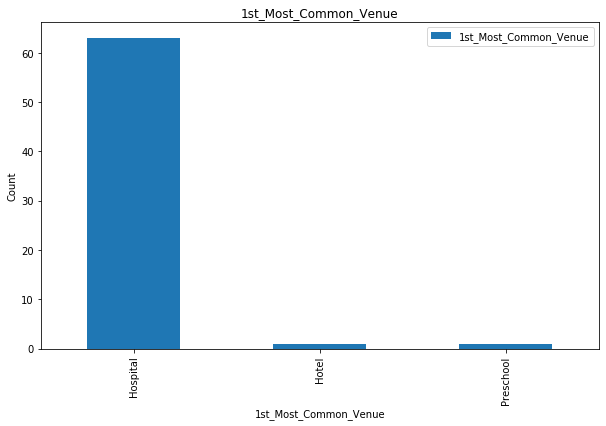

In [195]:
# Venue Details of Cluster 0 - top 1, 2 and 3
dff0=df_clus0.groupby(['1st_Most_Common_Venue'])[["1st_Most_Common_Venue"]].count()
dff0.plot(kind='bar', figsize=(10, 6), )
plt.xlabel('1st_Most_Common_Venue') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('1st_Most_Common_Venue') # add title to the plot
plt.show()

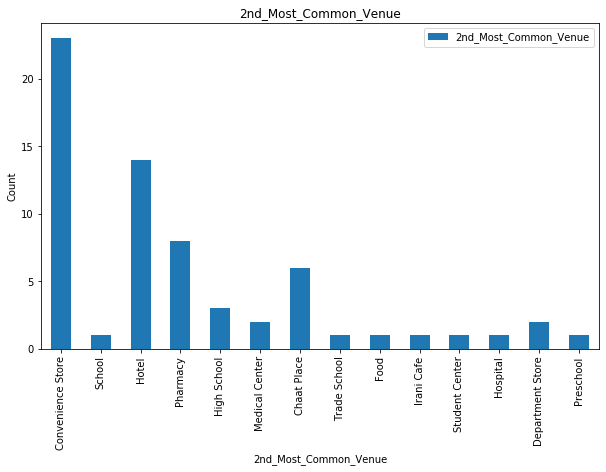

In [193]:
dff=df_clus0.groupby(['2nd_Most_Common_Venue'], sort=False)[["2nd_Most_Common_Venue"]].count()
dff.plot(kind='bar', figsize=(10, 6), )

plt.xlabel('2nd_Most_Common_Venue') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('2nd_Most_Common_Venue') # add title to the plot
plt.show()

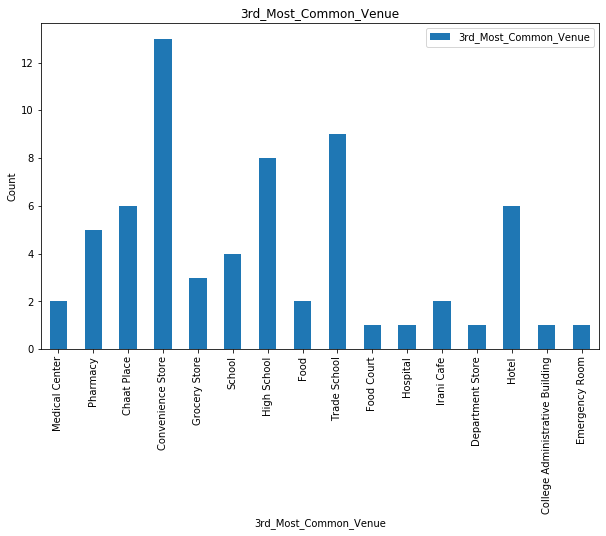

In [197]:
dff0_3=df_clus0.groupby(['3rd_Most_Common_Venue'], sort=False)[["3rd_Most_Common_Venue"]].count()
dff0_3.plot(kind='bar', figsize=(10, 6), )
plt.xlabel('3rd_Most_Common_Venue') # add to x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('3rd_Most_Common_Venue') # add title to the plot
plt.show()

## <center>Cluster 1 Analysis </center>

In [132]:
df_clus1=hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 1]
df_clus1

,Neighborhood,Latitude,Longitude,Cluster Labels,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
3,Adikmet,17.406944,78.512778,1,Convenience Store,Hospital,Pharmacy,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
8,Amberpet,17.390833,78.523611,1,Convenience Store,Hospital,School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
12,"Azamabad, Hyderabad",17.413700,78.502900,1,Hospital,Convenience Store,Pharmacy,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
23,Begumpet,17.445000,78.469444,1,Hospital,Convenience Store,Emergency Room,Indian Sweet Shop,High School,Trade School,College Administrative Building,College Classroom,Department Store,Food
28,Bowenpally,17.476111,78.482778,1,Department Store,Trade School,Hospital,College Administrative Building,College Classroom,Convenience Store,Emergency Room,Food,Food Court,Gas Station
29,Brahman Vaadi,17.437700,78.464500,1,Hospital,Convenience Store,Trade School,Pharmacy,Emergency Room,Food Court,High School,College Administrative Building,College Classroom,Department Store
30,Chaderghat,17.366667,78.500000,1,Hospital,School,Convenience Store,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
32,Chanchalguda,17.368900,78.496500,1,Hospital,School,Convenience Store,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court
34,Chikkadpally,17.403333,78.498611,1,Convenience Store,Hospital,Pharmacy,High School,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food
40,Dilsukhnagar,17.368889,78.524722,1,Hospital,Convenience Store,Trade School,College Administrative Building,College Classroom,Department Store,Emergency Room,Food,Food Court,Gas Station


In [143]:
df_clus1.groupby(['1st_Most_Common_Venue'])[["1st_Most_Common_Venue"]].count()

,1st_Most_Common_Venue
1st_Most_Common_Venue,
College Administrative Building,1
College Classroom,1
Convenience Store,11
Department Store,2
Hospital,18
School,4
Student Center,1
Supermarket,1


In [144]:
df_clus1.groupby(['2nd_Most_Common_Venue'])[["2nd_Most_Common_Venue"]].count()

,2nd_Most_Common_Venue
2nd_Most_Common_Venue,
Convenience Store,17
Hospital,7
Pharmacy,2
School,6
Trade School,7


In [173]:
df_clus1.groupby(['3rd_Most_Common_Venue'])[["3rd_Most_Common_Venue"]].count()

,3rd_Most_Common_Venue
3rd_Most_Common_Venue,
Convenience Store,5
Emergency Room,1
High School,3
Hospital,7
Pharmacy,8
School,2
Supermarket,2
Trade School,11


## <center>Cluster 2 Analysis</center>

In [146]:
df_clus2= hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 2]
df_clus2

,Neighborhood,Latitude,Longitude,Cluster Labels,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
2,Abids,17.366111,78.476111,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
4,Afzal Gunj,17.373333,78.470833,2,Hospital,Chaat Place,School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
6,Alijah Kotla,17.357222,78.476944,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
22,Begum Bazaar,17.373333,78.473889,2,Hospital,Chaat Place,School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
33,Chatta Bazaar,17.368800,78.479200,2,Hospital,Chaat Place,School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
37,Dabirpura,17.366111,78.476111,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
51,Gulzar Houz,17.363333,78.475000,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
65,Khilwat,17.357900,78.470200,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
71,Laad Bazaar,17.361944,78.472778,2,Hospital,School,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
74,Lal Darwaza,17.350000,78.483333,2,School,Trade School,Hospital,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court


In [147]:
df_clus2.groupby(['1st_Most_Common_Venue'])[["1st_Most_Common_Venue"]].count()

,1st_Most_Common_Venue
1st_Most_Common_Venue,
Hospital,13
School,3


In [148]:
df_clus2.groupby(['2nd_Most_Common_Venue'])[["2nd_Most_Common_Venue"]].count()

,2nd_Most_Common_Venue
2nd_Most_Common_Venue,
Chaat Place,4
Grocery Store,1
School,9
Trade School,2


In [149]:
df_clus2.groupby(['3rd_Most_Common_Venue'])[["3rd_Most_Common_Venue"]].count()

,3rd_Most_Common_Venue
3rd_Most_Common_Venue,
Hospital,2
School,4
Trade School,10


## <center>Cluster 3 Analysis</center>

In [150]:
df_clus3=hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 3]
df_clus3

,Neighborhood,Latitude,Longitude,Cluster Labels,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
42,ECIL 'X' Roads,17.451749,78.567116,3,Gas Station,Trade School,Hospital,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court
52,Habsiguda,17.419167,78.541389,3,Gas Station,High School,Trade School,Hospital,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food
88,Mallapur,17.450000,78.566667,3,Gas Station,Trade School,Hospital,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court


In [151]:
df_clus3.groupby(['1st_Most_Common_Venue'])[["1st_Most_Common_Venue"]].count()

,1st_Most_Common_Venue
1st_Most_Common_Venue,
Gas Station,3


In [152]:
df_clus3.groupby(['2nd_Most_Common_Venue'])[["2nd_Most_Common_Venue"]].count()

,2nd_Most_Common_Venue
2nd_Most_Common_Venue,
High School,1
Trade School,2


In [153]:
df_clus3.groupby(['3rd_Most_Common_Venue'])[["3rd_Most_Common_Venue"]].count()

,3rd_Most_Common_Venue
3rd_Most_Common_Venue,
Hospital,2
Trade School,1


## <center>Cluster 4 Analysis</center>

In [154]:
df_clus4=hyderabad_merged.loc[hyderabad_merged['Cluster Labels'] == 4]
df_clus4

,Neighborhood,Latitude,Longitude,Cluster Labels,1st_Most_Common_Venue,2nd_Most_Common_Venue,3rd_Most_Common_Venue,4th_Most_Common_Venue,5th_Most_Common_Venue,6th_Most_Common_Venue,7th_Most_Common_Venue,8th_Most_Common_Venue,9th_Most_Common_Venue,10th_Most_Common_Venue
7,Allwyn Colony,17.483333,78.416667,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
24,Bharat Nagar,17.463333,78.428889,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
31,Champapet,17.348333,78.550833,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
39,Dhoolpet,17.374444,78.460833,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
43,Erragadda,17.483333,78.416667,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
50,Gudimalkapur,17.378800,78.437400,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
57,Izzat Nagar,17.467700,78.379800,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
66,"Kondapur, Ranga Reddy district",17.483333,78.416667,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
69,Kukatpally,17.483333,78.416667,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station
73,Lal Bahadur Nagar,17.348333,78.550833,4,Hospital,Trade School,College Administrative Building,College Classroom,Convenience Store,Department Store,Emergency Room,Food,Food Court,Gas Station


In [155]:
df_clus4.groupby(['1st_Most_Common_Venue'])[["1st_Most_Common_Venue"]].count()

,1st_Most_Common_Venue
1st_Most_Common_Venue,
Hospital,22


In [156]:
df_clus4.groupby(['2nd_Most_Common_Venue'])[["2nd_Most_Common_Venue"]].count()

,2nd_Most_Common_Venue
2nd_Most_Common_Venue,
High School,1
Trade School,21


In [157]:
df_clus4.groupby(['3rd_Most_Common_Venue'])[["3rd_Most_Common_Venue"]].count()

,3rd_Most_Common_Venue
3rd_Most_Common_Venue,
College Administrative Building,20
Convenience Store,1
Trade School,1


## <center> End of Analysis</center>